# Heart Disease Analysis

### Codecademy Bootcamp - Applied Data Science with Python
---
**Heart Disease Research Part I & II**

In this project, you’ll investigate some data from a sample patients who were evaluated for heart disease at the Cleveland Clinic Foundation. The data was downloaded from the UCI Machine Learning Repository and then cleaned for analysis.

The principal investigators responsible for data collection were:

* Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
* University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
* University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
* V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.


## Project Summary
---

### Project Overview
This analysis investigates cardiovascular risk factors using clinical data from the Cleveland Clinic Foundation. The study examines whether patients diagnosed with heart disease exhibit significantly elevated cholesterol levels and fasting blood sugar compared to clinical thresholds and population baselines.

### Key Research Questions
1. **Cholesterol Analysis**: Do patients with heart disease have mean cholesterol levels significantly higher than 240 mg/dl?
2. **Fasting Blood Sugar**: Is the prevalence of elevated fasting blood sugar (>120 mg/dl) in this clinical sample significantly higher than the 1988 U.S. national average of 8%?
3. **Comparative Analysis**: How do cardiovascular metrics differ between patients with and without heart disease?

### Dataset Information
- **Total Patients**: 303
- **Variables**: 9 clinical measurements
- **Outcome**: Heart disease presence/absence
- **Source**: UCI Machine Learning Repository

### Statistical Approach
- One-sample t-tests for threshold comparisons
- Two-sample t-tests for group comparisons
- Binomial test for proportion analysis
- Effect size calculations (Cohen's d)
- Assumption checking (normality, equal variance)

---

## Heart Disease Research Part I

### Setup & Data Ingestion
---
**In this initial phase, we:**
* Import specialized libraries for data manipulation (pandas, numpy, scipy.stats, statsmodels.stats.multicomp).
* Configure the visualization environment (seaborn, matplotlib).

In [1]:
# Run this cell to install necessary packages for the notebook.

#!pip install pandas numpy matplotlib seaborn scipy statsmodels

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import ttest_1samp
from scipy.stats import binomtest
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency


### Data Exploration & Quality Assessment
---
**In this initial phase, we:**
* Load the clinical records from **heart_disease.csv**
* Use a filtering operation to create a subset of data
* Inspect the data 

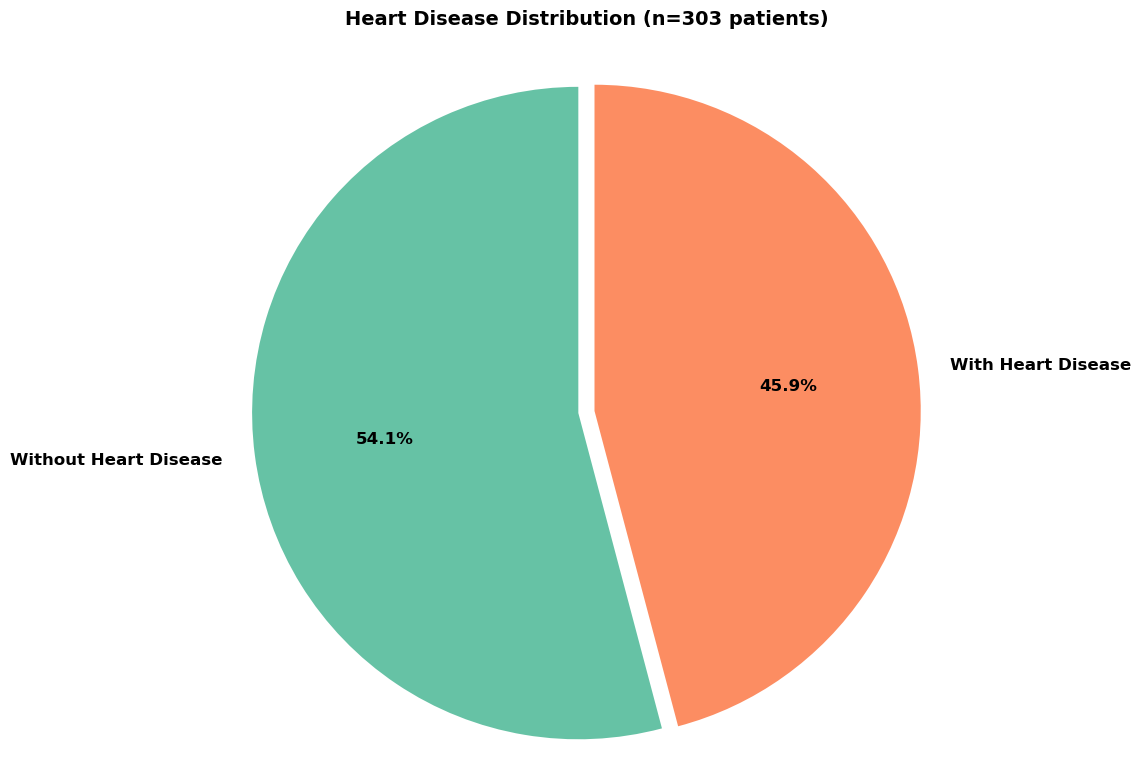

Total patients: 303
Without heart disease: 164 (54.1%)
With heart disease: 139 (45.9%)


In [3]:
# load data
heart = pd.read_csv('heart_disease.csv')
# create subsets for heart disease presence and absence

yes_hd = heart[heart.heart_disease == 'presence']
no_hd = heart[heart.heart_disease == 'absence']

plt.figure(figsize=(8, 8))

sizes = [len(no_hd), len(yes_hd)]
labels = ['Without Heart Disease', 'With Heart Disease']
colors = sns.color_palette('Set2', 2)
explode = (0.05, 0)

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, explode=explode, textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title(f'Heart Disease Distribution (n={len(heart)} patients)', 
          fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout(pad=0.5)
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)
plt.show()

print(f"Total patients: {len(heart)}")
print(f"Without heart disease: {len(no_hd)} ({len(no_hd)/len(heart)*100:.1f}%)")
print(f"With heart disease: {len(yes_hd)} ({len(yes_hd)/len(heart)*100:.1f}%)")


### Create a Cohen's d Function

Cohen's d measures the standardized difference between two means, providing context beyond p-values.

In [4]:
def cohens_d(group1, group2):
    """
    Calculate Cohen's d for effect size between two groups.
    
    Parameters:
    - group1, group2: array-like data for two groups
    
    Returns:
    - d: Cohen's d effect size
    - interpretation: string describing the effect size magnitude
    """
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (mean1 - mean2) / pooled_std
    
    # Interpretation
    abs_d = abs(d)
    if abs_d < 0.2:
        interpretation = "negligible"
    elif abs_d < 0.5:
        interpretation = "small"
    elif abs_d < 0.8:
        interpretation = "medium"
    else:
        interpretation = "large"
    
    return d, interpretation


### Data Quality Assessment
---
Before analysis, let's check for missing values, duplicates, and data integrity issues.

In [5]:
# Data quality check
print('--- DATA QUALITY CHECK ---')

print(f"\nDataframe shape: {heart.shape[0]} rows x {heart.shape[1]} columns")

# check for missing values
print(f"\nMissing values in each column:\n{heart.isnull().sum()}")
missing = heart.isnull().sum()
if missing.sum() == 0:
    print(f"\n  ✓ No missing values detected")
else:
    print(f"\n  Missing values detected:\n{missing[missing > 0]}")

# check for duplicates
duplicates = heart.duplicated().sum()
if duplicates == 0:
    print(f"\n  ✓ No duplicate rows detected")
else:
    print(f"\n  Duplicate rows detected: {duplicates}")

# data types and basic statistics
print(f"\nData types of each column:\n{heart.dtypes}")
print(f"\nStatistical summary of numerical columns:\n{heart.describe()}")
print(f"\nUnique values in categorical columns:")

# list unique values in categorical columns
categorical_cols = heart.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {heart[col].unique()}")
print('--- END DATA QUALITY CHECK ---')

--- DATA QUALITY CHECK ---

Dataframe shape: 303 rows x 9 columns

Missing values in each column:
age              0
sex              0
trestbps         0
chol             0
cp               0
exang            0
fbs              0
thalach          0
heart_disease    0
dtype: int64

  ✓ No missing values detected

  ✓ No duplicate rows detected

Data types of each column:
age               int64
sex              object
trestbps          int64
chol              int64
cp               object
exang             int64
fbs               int64
thalach           int64
heart_disease    object
dtype: object

Statistical summary of numerical columns:
              age    trestbps        chol       exang         fbs     thalach
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000
mean    54.438944  131.689769  246.693069    0.326733    0.148515  149.607261
std      9.038662   17.599748   51.776918    0.469794    0.356198   22.875003
min     29.000000   94.000000  126.000000

---

#### Inspect the "Presence" group (Patients with heart disease)

In [6]:
# Inspect the "Presence" group (Patients with heart disease)

print("--- YES HEART DISEASE: HEAD ---")
print(yes_hd.head())
print("--- YES HEART DISEASE: INFO ---")
print(yes_hd.info())
print("--- YES HEART DISEASE: DESCRIBE ---")
print(yes_hd.describe())


--- YES HEART DISEASE: HEAD ---
   age     sex  trestbps  chol            cp  exang  fbs  thalach  \
1   67    male       160   286  asymptomatic      1    0      108   
2   67    male       120   229  asymptomatic      1    0      129   
6   62  female       140   268  asymptomatic      0    0      160   
8   63    male       130   254  asymptomatic      0    0      147   
9   53    male       140   203  asymptomatic      1    1      155   

  heart_disease  
1      presence  
2      presence  
6      presence  
8      presence  
9      presence  
--- YES HEART DISEASE: INFO ---
<class 'pandas.core.frame.DataFrame'>
Index: 139 entries, 1 to 301
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            139 non-null    int64 
 1   sex            139 non-null    object
 2   trestbps       139 non-null    int64 
 3   chol           139 non-null    int64 
 4   cp             139 non-null    object
 5   exang   

---

#### Inspect the "Presence" group (Patients without heart disease)

In [7]:
# Inspect the "Presence" group (Patients without heart disease)

print("--- NO HEART DISEASE: HEAD ---")
print(no_hd.head())
print("--- NO HEART DISEASE: INFO ---")
print(no_hd.info())
print("--- NO HEART DISEASE: DESCRIBE ---")
print(no_hd.describe())

--- NO HEART DISEASE: HEAD ---
   age     sex  trestbps  chol                cp  exang  fbs  thalach  \
0   63    male       145   233    typical angina      0    1      150   
3   37    male       130   250  non-anginal pain      0    0      187   
4   41  female       130   204   atypical angina      0    0      172   
5   56    male       120   236   atypical angina      0    0      178   
7   57  female       120   354      asymptomatic      1    0      163   

  heart_disease  
0       absence  
3       absence  
4       absence  
5       absence  
7       absence  
--- NO HEART DISEASE: INFO ---
<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 0 to 302
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            164 non-null    int64 
 1   sex            164 non-null    object
 2   trestbps       164 non-null    int64 
 3   chol           164 non-null    int64 
 4   cp             164 non-null  

### Dataset Variable Dictionary

| Variable Name | Description                              | DType   | Key/Notes                                                            |
| ------------- | ---------------------------------------- | --------| -------------------------------------------------------------------- |
| age           | Age of the patient                       | int64   | Years                                                                |
| sex           | Gender of the patient                    | object  | 1 = Male; 0 = Female                                                 |
| trestbps      | Resting blood pressure                   | int64   | mm Hg                                                                |
| chol          | Serum cholesterol                        | int64   | mg/dl                                                                |
| cp            | Chest pain type                          | object  | 'Typical'; 'Atypical'; 'Non-anginal'; 'Asymptomatic'                 |
| exang         | Exercise induced angina                  | int64   | 1 = Yes; 0 = No                                                      |  
| fbs           | Fasting blood sugar                      | int64   | 1 = > 120 mg/dl; 0 = < 120 mg/dl                                     |
| thalach       | Max heart rate achieved in exercise test | int64   | Beats per minute                                                     |   
| heart_disease | Diagnosis of heart disease               | object  | 'presence' or 'absence'                                              |



---

## Cholesterol Analysis
---
**Hypothesis Testing:**
* **Null:** People with heart disease have an average cholesterol level equal to 240 mg/dl
* **Alternative:** People with heart disease have an average cholesterol level that is greater than 240 mg/dl

----
### Cholesterol Analysis for Patients with Heart Disease

In [8]:
# extract cholesterol levels for patients with heart disease
chol_hd = yes_hd.chol

# summarize cholesterol levels for patients with heart disease
print((yes_hd[['chol']].describe().T))

# compare to cut-off for high cholesterol
tstat, pval = ttest_1samp(chol_hd, 240)
one_tail_pval = pval / 2

tstat_chol, pval_chol = ttest_ind(yes_hd.chol, no_hd.chol)
d_chol, interp_chol = cohens_d(yes_hd.chol, no_hd.chol)

# calculate mean cholesterol level for patients with heart disease
print(f"\nMean cholesterol level for patients with heart disease: {np.mean(chol_hd):.2f} mg/dl")

print(f"\np-value for cholesterol level comparison: {one_tail_pval:.4f}\n")

alpha = 0.05
if one_tail_pval < alpha and yes_hd.chol.mean() > 240:
    print("Conclusion: Reject the Null. Evidence suggests patients with heart disease have an average cholesterol level that is greater than 240 mg/dl")
    print(f"\nMean cholesterol level for patients with heart disease: {np.mean(chol_hd):.2f} mg/dl")
else:
    print("Conclusion: Fail to Reject. Mean is not significantly higher than 240 mg/dl.")
    print(f"\nMean cholesterol level for patients with heart disease: {np.mean(chol_hd):.2f} mg/dl")

# One-sample Cohen's d for cholesterol threshold analysis
d_one_sample = (np.mean(chol_hd) - 240) / np.std(chol_hd, ddof=1)

# Interpretation for one-sample effect size
abs_d = abs(d_one_sample)
if abs_d < 0.2:
    effect_interp = 'negligible'
elif abs_d < 0.5:
    effect_interp = 'small'
elif abs_d < 0.8:
    effect_interp = 'medium'
else:
    effect_interp = 'large'

print(f"\n--- ONE-SAMPLE EFFECT SIZE ANALYSIS ---")
print(f"One-sample Cohen's d (HD group vs 240 mg/dL threshold): {d_one_sample:.3f}")
print(f"Effect size magnitude: {effect_interp}")


      count       mean        std    min    25%    50%    75%    max
chol  139.0  251.47482  49.486835  131.0  217.5  249.0  283.5  409.0

Mean cholesterol level for patients with heart disease: 251.47 mg/dl

p-value for cholesterol level comparison: 0.0035

Conclusion: Reject the Null. Evidence suggests patients with heart disease have an average cholesterol level that is greater than 240 mg/dl

Mean cholesterol level for patients with heart disease: 251.47 mg/dl

--- ONE-SAMPLE EFFECT SIZE ANALYSIS ---
One-sample Cohen's d (HD group vs 240 mg/dL threshold): 0.232
Effect size magnitude: small


----
### Cholesterol Analysis for Patients without Heart Disease

In [9]:
# extract cholesterol levels for patients without heart disease
chol_no_hd = no_hd.chol

# print cholesterol descriptive statistics for patients without heart disease
print((no_hd[['chol']].describe().T))

# compare to cut-off for high cholesterol
tstat, pval = ttest_1samp(chol_no_hd, 240)
one_tail_pval = pval / 2

tstat_chol, pval_chol = ttest_ind(yes_hd.chol, no_hd.chol)
d_chol, interp_chol = cohens_d(yes_hd.chol, no_hd.chol)

# calculate mean cholesterol level for patients without heart disease with 2 decimal places.
print(f"\nMean cholesterol level for patients without heart disease: {np.mean(chol_no_hd):.2f} mg/dl")

# calculate p-value for one-tailed test with 4 decimal places.
print(f"\np-value for cholesterol level comparison: {one_tail_pval:.4f}\n")

alpha = 0.05
if one_tail_pval < alpha and no_hd.chol.mean() > 240:
    print("Conclusion: Reject the Null. Evidence suggests the mean is significantly > 240 mg/dl.")
    print(f"\nMean cholesterol level for patients without heart disease: {np.mean(chol_no_hd):.2f} mg/dl")
else:
    print("Conclusion: Fail to Reject. Mean is not significantly higher than 240 mg/dl.")
    print(f"\nMean cholesterol level for patients without heart disease: {np.mean(chol_no_hd):.2f} mg/dl")

print(f"\n--- EFFECT SIZE ANALYSIS ---")
print(f"Cohen's d: {d_chol:.3f}")
print(f"Effect size magnitude: {interp_chol}")
print(f"Interpretation: The difference in cholesterol levels between groups")
print(f"represents a {interp_chol} effect size.")

      count        mean       std    min     25%    50%     75%    max
chol  164.0  242.640244  53.45658  126.0  208.75  234.5  267.25  564.0

Mean cholesterol level for patients without heart disease: 242.64 mg/dl

p-value for cholesterol level comparison: 0.2640

Conclusion: Fail to Reject. Mean is not significantly higher than 240 mg/dl.

Mean cholesterol level for patients without heart disease: 242.64 mg/dl

--- EFFECT SIZE ANALYSIS ---
Cohen's d: 0.171
Effect size magnitude: negligible
Interpretation: The difference in cholesterol levels between groups
represents a negligible effect size.


---

## Fasting Blood Sugar Analysis

**Objective:** To determine if the prevalence of high fasting blood sugar in our clinical sample significantly exceeds the 1988 U.S. national average of 8%.


---

**Data Summary and Population Comparison**

In [10]:
# Using the full dataset to determine the number of patients within the dataset
num_patients = heart.shape[0]
print(f"Total number of patients in the dataset: {num_patients}")

# Determine number of patients with fasting blood sugar > 120 mg/dl
num_highfbs_patients = np.sum(heart.fbs)
print(f"Number of patients with fasting blood sugar > 120 mg/dl: {num_highfbs_patients}")

# Calculate expected number of patients based on 8% national average for patients with fbs > 120 mg/dl 
print(f"Expected number of patients with fasting blood sugar > 120 mg/dl: {0.08 * num_patients:.2f}")

Total number of patients in the dataset: 303
Number of patients with fasting blood sugar > 120 mg/dl: 45
Expected number of patients with fasting blood sugar > 120 mg/dl: 24.24


---
### Inferential Statistics: Binomial Test
We will now perform a **Binomial Test** to see if the observed rate (45/303) is significantly higher than the 8% null probability.

* **Null Hypothesis:** This sample was drawn from a population where 8% of people have fasting blood sugar > 120 mg/dl
* **Alternative Hypothesis:** This sample was drawn from a population where more than 8% of people have fasting blood sugar > 120 mg/dl

In [11]:
# Calculate percentage of patients with fasting blood sugar > 120 mg/dl
percentage = num_highfbs_patients/num_patients *100
print(f"Percentage of patients with fasting blood sugar > 120 mg/dl: {percentage:.2f}%\n")

# Perform binomial test
results = binomtest(k=num_highfbs_patients, n=num_patients, p=0.08, alternative='greater')
p_value = results.pvalue

print(f"Binomial test results: {results}\n")
print(f"P-value for fasting blood sugar > 120 mg/dl comparison: {p_value:.7F}")

# Determine if we reject or fail to reject the null hypothesis
alpha = 0.05
if p_value < alpha:
    print("\nResult: STATISTICALLY SIGNIFICANT\n")
    print("Conclusion: Reject the null hypothesis.")
else:
    print("\nResult: NOT SIGNIFICANT\n")
    print("Conclusion: Fail to reject the null hypothesis.")

Percentage of patients with fasting blood sugar > 120 mg/dl: 14.85%

Binomial test results: BinomTestResult(k=45, n=303, alternative='greater', statistic=0.1485148514851485, pvalue=4.689471951448875e-05)

P-value for fasting blood sugar > 120 mg/dl comparison: 0.0000469

Result: STATISTICALLY SIGNIFICANT

Conclusion: Reject the null hypothesis.


## Heart Disease Research – Part I

### Key Findings

**1. Cholesterol Analysis**
* The evidence suggests patients with heart disease have on average higher cholesterol level of 251.47 mg/dl which is higher than the expected results of 240 mg/dl
  * p-value for cholesterol level comparison: 0.0035
* The evidence suggest patients without heart disease have on average cholesterol levels of 242.64 mg/dl which are close to the expected results of 240 mg/dl
  * p-value for cholesterol level comparison: 0.2640

**2. Fasting Blood Sugar (FBS)**
* Percentage of patients with fasting blood sugar > 120 mg/dl: 14.85%
  * This is a higher than expected results as the general population would be 8%
Binomial Test Results:
* P-value for fasting blood sugar > 120 mg/dl comparison: 0.0000469
* Results are **STATISTICALLY SIGNIFICANT** because the rate of high FBS is significantly greater than 8% (p < 0.05)
  * Conclusion: Reject the null hypothesis.

<br>
<small> Note on Data Limitations: The 8% expected rate used in this binomial test originates from 1988. It's recommended to revise this analysis with recent health statistics, as modern rates of high fasting blood sugar have likely changed over the past three decade.</small>


----

## Heart Disease Research Part II



---
### Analysis for Max Heart Rate Achieved in Exercise Test by Heart Disease Status

<Figure size 640x480 with 0 Axes>

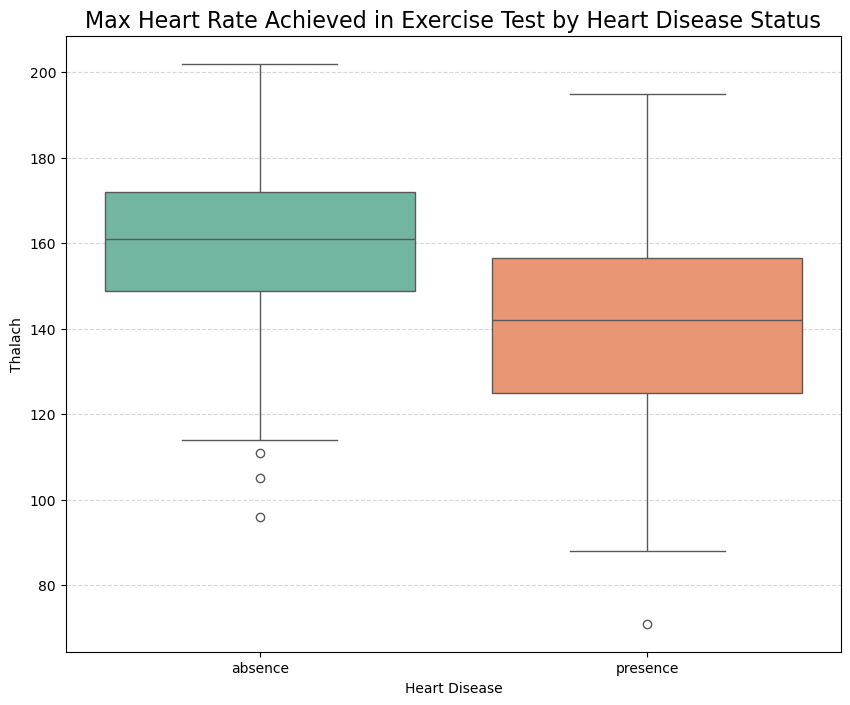

               STATISTICAL SUMMARY                
--------------------------------------------------
Mean Difference:               19.12 Beats per minute
Median Difference:             19.00 Beats per minute
T-Test P-Value For Thalach:    3.456964908430172e-14

Conclusion: Reject the Null. There is a significant difference in `thalach` between patients with and without heart disease.

--- EFFECT SIZE ANALYSIS ---
Cohen's d: -0.918
Effect size magnitude: large
Mean difference: 19.12 bpm

Interpretation: Patients without heart disease have largely
higher maximum heart rates compared to those with heart disease.


In [12]:

plt.clf()
plt.figure(figsize=(10, 8))
sns.boxplot(data=heart, x='heart_disease', y='thalach', hue='heart_disease', palette='Set2', legend=False )

plt.title('Max Heart Rate Achieved in Exercise Test by Heart Disease Status', fontsize=16)
plt.xlabel('Heart Disease')
plt.ylabel('Thalach')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# select `thalach` for hd patients
thalach_hd = heart.thalach[heart.heart_disease == 'presence']

# select `thalach` for non-hd patients
thalach_no_hd = heart.thalach[heart.heart_disease == 'absence']

# perform two-sample t-test
tstat, pval = ttest_ind(thalach_hd, thalach_no_hd)
thalach_pval = pval

# calculate Cohen's d
tstat_thalach, pval_thalach = ttest_ind(thalach_hd, thalach_no_hd)
d_thalach, interp_thalach = cohens_d(thalach_hd, thalach_no_hd)

# Statistical summary visual 
print(f"{'STATISTICAL SUMMARY':^50}")
print("-" * 50)
print(f"Mean Difference:               {thalach_no_hd.mean() - thalach_hd.mean():.2f} Beats per minute")
print(f"Median Difference:             {thalach_no_hd.median() - thalach_hd.median():.2f} Beats per minute")
print(f"T-Test P-Value For Thalach:    {thalach_pval}")

alpha = 0.05
if pval < alpha:
    print(f"\nConclusion: Reject the Null. There is a significant difference in `thalach` between patients with and without heart disease.")

else:
    print(f"\nConclusion: Fail to Reject. There is no significant difference in `thalach` between patients with and without heart disease.")

print(f"\n--- EFFECT SIZE ANALYSIS ---")
print(f"Cohen's d: {d_thalach:.3f}")
print(f"Effect size magnitude: {interp_thalach}")
print(f"Mean difference: {thalach_no_hd.mean() - thalach_hd.mean():.2f} bpm")
print(f"\nInterpretation: Patients without heart disease have {interp_thalach}ly")
print(f"higher maximum heart rates compared to those with heart disease.")

---
### Analysis for Heart Age by Heart Disease Status

<Figure size 640x480 with 0 Axes>

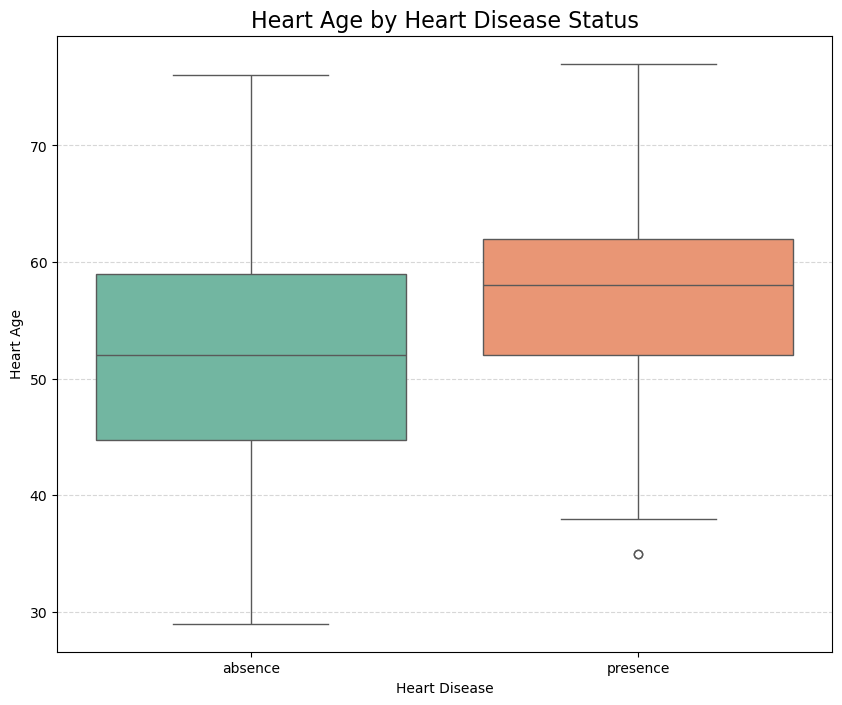

               STATISTICAL SUMMARY                
--------------------------------------------------
Mean Difference:           4.04 years
Median Difference:         6.00 years
T-Test P-Value For Age:    8.955636917529706e-05

Conclusion: Reject the Null. There is a significant difference in `age` between patients with and without heart disease.

--- AGE COMPARISON ---
Mean age (HD present): 56.63 years
Mean age (HD absent): 52.59 years
T-statistic: 3.9711, p-value: 0.0001
Cohen's d: 0.458 (small effect)


In [13]:
# Create a graph age
plt.clf()
plt.figure(figsize=(10, 8))
sns.boxplot(data=heart, x='heart_disease', y='age', hue='heart_disease', palette='Set2')

plt.title('Heart Age by Heart Disease Status', fontsize=16)
plt.xlabel('Heart Disease')
plt.ylabel('Heart Age')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# select `age` for hd patients
age_hd = heart.age[heart.heart_disease == 'presence']
age_no_hd = heart.age[heart.heart_disease == 'absence']

age_hd = heart[heart.heart_disease == 'presence']['age']
age_no_hd = heart[heart.heart_disease == 'absence']['age']

# Two-sample t-test for age
tstat, age_pval = ttest_ind(age_hd, age_no_hd)

# calculate Cohen's d for age
tstat_age, pval_age = ttest_ind(age_hd, age_no_hd)
d_age, interp_age = cohens_d(age_hd, age_no_hd)

# Statistical summary visual 
print(f"{'STATISTICAL SUMMARY':^50}")
print("-" * 50)
print(f"Mean Difference:           {age_hd.mean() - age_no_hd.mean():.2f} years")
print(f"Median Difference:         {age_hd.median() - age_no_hd.median():.2f} years")
print(f"T-Test P-Value For Age:    {age_pval}")

alpha = 0.05
if age_pval < alpha:
    print(f"\nConclusion: Reject the Null. There is a significant difference in `age` between patients with and without heart disease.")

else:
    print(f"\nConclusion: Fail to Reject. There is no significant difference in `age` between patients with and without heart disease.")

print(f"\n--- AGE COMPARISON ---")
print(f"Mean age (HD present): {age_hd.mean():.2f} years")
print(f"Mean age (HD absent): {age_no_hd.mean():.2f} years")
print(f"T-statistic: {tstat_age:.4f}, p-value: {pval_age:.4f}")
print(f"Cohen's d: {d_age:.3f} ({interp_age} effect)")

---
### Analysis for Resting Blood Pressure by Heart Disease Status

<Figure size 640x480 with 0 Axes>

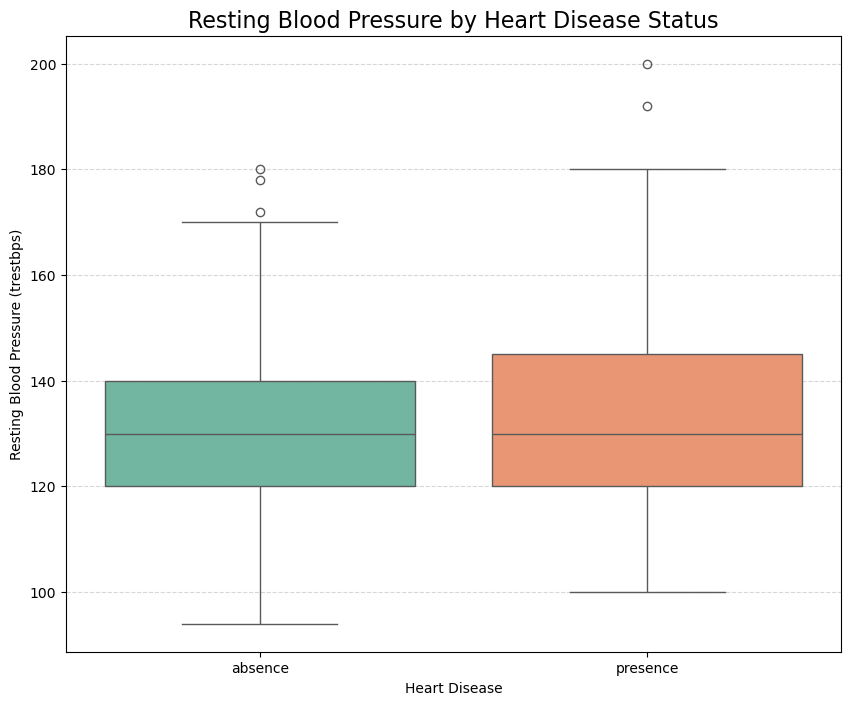

               STATISTICAL SUMMARY                
--------------------------------------------------
Mean Difference:               5.3183 mm Hg
Median Difference:             0.0 mm Hg
T-Test P-Value For trestbps:   0.008548268928594928

Conclusion: Reject the Null. There is a significant difference in Resting Blood Pressure (trestbps) between patients with and without heart disease.

--- Resting Blood Pressure COMPARISON ---
Mean trestbps (HD present): 134.57 mm Hg
Mean trestbps (HD absent): 129.25 mm Hg
T-statistic: 2.6470, p-value: 0.0085
Cohen's d: 0.305 (small effect)


In [14]:
# Create a graph trestbps

plt.clf()
plt.figure(figsize=(10, 8))
sns.boxplot(data=heart, x='heart_disease', y='trestbps', hue='heart_disease', palette='Set2')

plt.title('Resting Blood Pressure by Heart Disease Status', fontsize=16)
plt.xlabel('Heart Disease')
plt.ylabel('Resting Blood Pressure (trestbps)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

trestbps_hd = heart.trestbps[heart.heart_disease == 'presence']
trestbps_no_hd = heart.trestbps[heart.heart_disease == 'absence']

# perform two-sample t-test
tstat, pval = ttest_ind(trestbps_hd, trestbps_no_hd)
trestbps_pval = pval

# calculate Cohen's d
tstat_trestbps, pval_trestbps = ttest_ind(trestbps_hd, trestbps_no_hd)
d_trestbps, interp_trestbps = cohens_d(trestbps_hd, trestbps_no_hd)

# Statistical summary visual 
print(f"{'STATISTICAL SUMMARY':^50}")
print("-" * 50)
print(f"Mean Difference:               {trestbps_hd.mean() - trestbps_no_hd.mean():.4f} mm Hg")
print(f"Median Difference:             {trestbps_hd.median() - trestbps_no_hd.median()} mm Hg")
print(f"T-Test P-Value For trestbps:   {trestbps_pval}")

alpha = 0.05
if trestbps_pval < alpha:
    print(f"\nConclusion: Reject the Null. There is a significant difference in Resting Blood Pressure (trestbps) between patients with and without heart disease.")

else:
    print(f"\nConclusion: Fail to Reject. There is no significant difference in Resting Blood Pressure (trestbps) between patients with and without heart disease.")


print(f"\n--- Resting Blood Pressure COMPARISON ---")
print(f"Mean trestbps (HD present): {trestbps_hd.mean():.2f} mm Hg")
print(f"Mean trestbps (HD absent): {trestbps_no_hd.mean():.2f} mm Hg")
print(f"T-statistic: {tstat_trestbps:.4f}, p-value: {pval_trestbps:.4f}")
print(f"Cohen's d: {d_trestbps:.3f} ({interp_trestbps} effect)")

---
### Analysis for Cholesterol by Heart Disease Status

<Figure size 640x480 with 0 Axes>

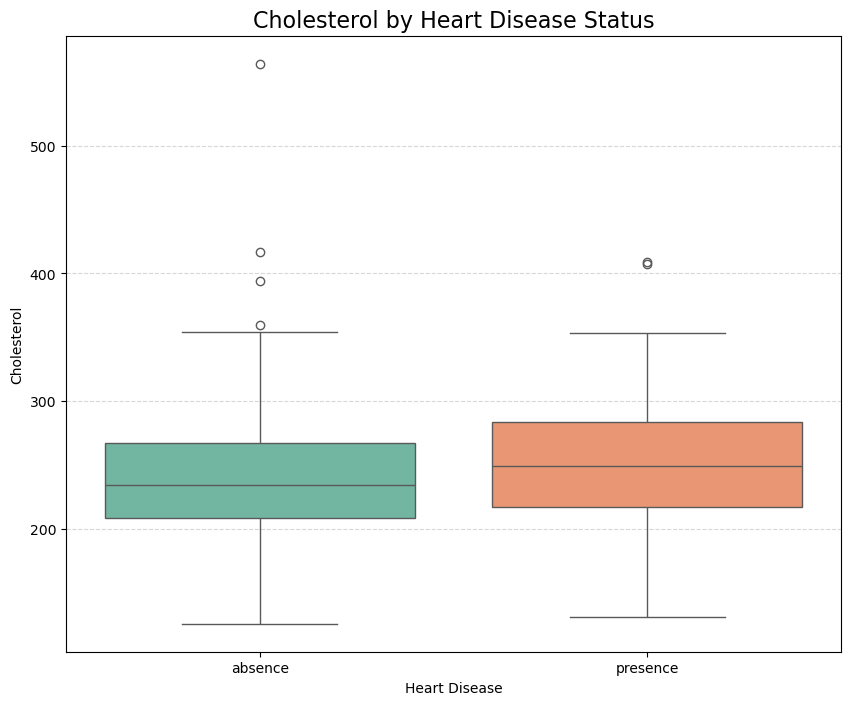

               STATISTICAL SUMMARY                
--------------------------------------------------
Mean Difference:                  8.8346 mg/dl
Median Difference:                14.5 mg/dl
T-Test P-Value For Cholesterol:   0.13914167020436527

Conclusion: Fail to Reject. There is no significant difference in Cholesterol (chol) between patients with and without heart disease.

--- Cholesterol COMPARISON ---
Mean chol (HD present): 251.47 mg/dl
Mean chol (HD absent): 242.64 mg/dl
T-statistic: 1.4829, p-value: 0.1391
Cohen's d: 0.171 (negligible effect)


In [15]:
# Create a graph cholesterol

plt.clf()
plt.figure(figsize=(10, 8))
sns.boxplot(data=heart, x='heart_disease', y='chol', hue='heart_disease', palette='Set2')

plt.title('Cholesterol by Heart Disease Status', fontsize=16)
plt.xlabel('Heart Disease')
plt.ylabel('Cholesterol')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

chol_hd = heart.chol[heart.heart_disease == 'presence']
chol_no_hd = heart.chol[heart.heart_disease == 'absence']

# perform two-sample t-test
tstat, pval = ttest_ind(chol_hd, chol_no_hd)
chol_pval = pval

# calculate Cohen's d
tstat_chol, pval_chol = ttest_ind(chol_hd, chol_no_hd)
d_chol, interp_chol = cohens_d(chol_hd, chol_no_hd)

# Statistical summary visual 
print(f"{'STATISTICAL SUMMARY':^50}")
print("-" * 50)
print(f"Mean Difference:                  {chol_hd.mean() - chol_no_hd.mean():.4f} mg/dl")
print(f"Median Difference:                {chol_hd.median() - chol_no_hd.median()} mg/dl")
print(f"T-Test P-Value For Cholesterol:   {chol_pval}")

alpha = 0.05
if pval < alpha:
    print(f"\nConclusion: Reject the Null. There is a significant difference in Cholesterol (chol) between patients with and without heart disease.")

else:
    print(f"\nConclusion: Fail to Reject. There is no significant difference in Cholesterol (chol) between patients with and without heart disease.")

print(f"\n--- Cholesterol COMPARISON ---")
print(f"Mean chol (HD present): {chol_hd.mean():.2f} mg/dl")
print(f"Mean chol (HD absent): {chol_no_hd.mean():.2f} mg/dl")
print(f"T-statistic: {tstat_chol:.4f}, p-value: {pval_chol:.4f}")
print(f"Cohen's d: {d_chol:.3f} ({interp_chol} effect)")

---
### Max Heart Rate Achieved in Exercise Test by Chest Pain Type

<Figure size 640x480 with 0 Axes>

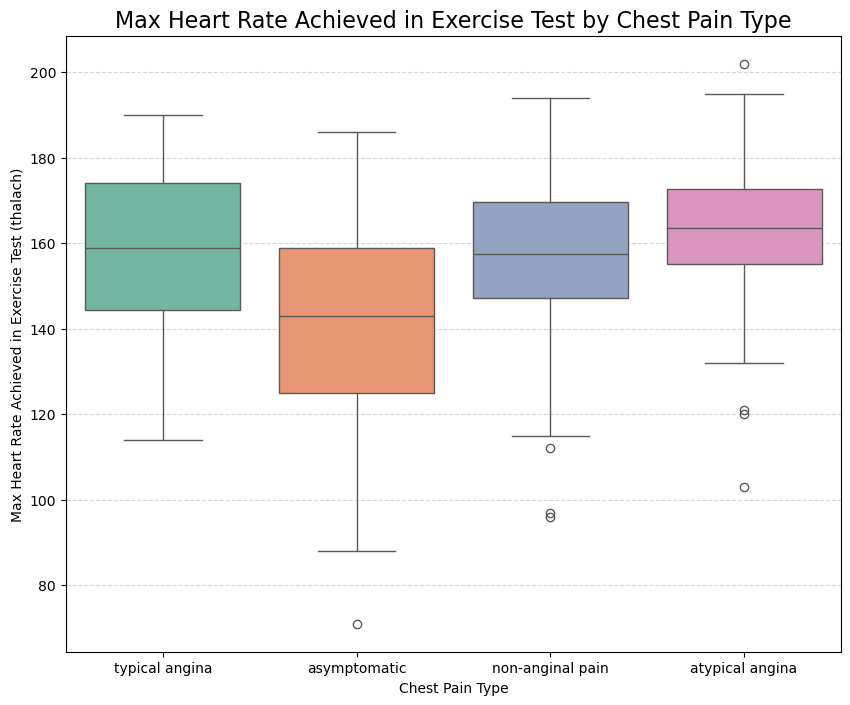

p-value for ANOVA:  1.9065505247706138e-10

Tukey's Range Test Output:           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------
    asymptomatic  atypical angina  21.7394    0.0  12.7442 30.7347   True
    asymptomatic non-anginal pain  14.7264    0.0   7.2583 22.1945   True
    asymptomatic   typical angina   15.276 0.0081   2.9707 27.5812   True
 atypical angina non-anginal pain   -7.013 0.2481 -16.7587  2.7327  False
 atypical angina   typical angina  -6.4635 0.6213 -20.2702  7.3432  False
non-anginal pain   typical angina   0.5495 0.9995 -12.3145 13.4136  False
-------------------------------------------------------------------------

Contingency Table of Heart Disease vs Chest Pain Type

 heart_disease     absence  presence
cp                                 
asymptomatic           39       105
atypical angina        41

In [16]:
# Create a graph thalach by chest pain type

plt.clf()
plt.figure(figsize=(10, 8))
sns.boxplot(data=heart, x='cp', y='thalach', hue='cp', palette='Set2')

plt.title('Max Heart Rate Achieved in Exercise Test by Chest Pain Type', fontsize=16)
plt.xlabel('Chest Pain Type')
plt.ylabel('Max Heart Rate Achieved in Exercise Test (thalach)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

thalach_typical = heart.thalach[heart.cp == 'typical angina']
thalach_asymptom = heart.thalach[heart.cp == 'asymptomatic']
thalach_nonangin = heart.thalach[heart.cp == 'non-anginal pain']
thalach_atypical = heart.thalach[heart.cp == 'atypical angina']

# perform one-way ANOVA
Fstat, pval = f_oneway(thalach_typical, thalach_asymptom, thalach_nonangin, thalach_atypical)
bpm_cp_pval = pval
print('p-value for ANOVA: ', bpm_cp_pval)

# run Tukey's range test
Tukey_output = pairwise_tukeyhsd(heart.thalach, heart.cp)
print(f"\nTukey's Range Test Output:{Tukey_output}")

# contingency table of heart disease vs cp
Xtab = pd.crosstab(heart.cp, heart.heart_disease)
print(f"\nContingency Table of Heart Disease vs Chest Pain Type\n\n {Xtab}")

# run chi-square test
chi2, pval, dof, exp = chi2_contingency(Xtab)
print(f"\n P-value for chi-square test: {pval}")


In [17]:
import pandas as pd

# Comprehensive Effect Size Summary Table
print("="*100)
print("SUMMARY TABLE: Effect Sizes and Statistical Significance")
print("="*100)

# Create summary DataFrame using actual calculated values
summary = pd.DataFrame({
    'Comparison': [
        'Max Heart Rate (HD vs No HD)',
        'Age (HD vs No HD)',
        'Resting BP (HD vs No HD)',
        'Cholesterol (HD vs No HD)',
    ],
    'Mean Difference': [
        f"{yes_hd.thalach.mean() - no_hd.thalach.mean():.2f} bpm",
        f"{yes_hd.age.mean() - no_hd.age.mean():.2f} years",
        f"{yes_hd.trestbps.mean() - no_hd.trestbps.mean():.2f} mmHg",
        f"{yes_hd.chol.mean() - no_hd.chol.mean():.2f} mg/dL",
    ],
    "Cohen's d": [
        f"{d_thalach:.3f}",
        f"{d_age:.3f}",
        f"{d_trestbps:.3f}",
        f"{d_chol:.3f}",
    ],
    'Effect Size': [
        interp_thalach.capitalize(),
        interp_age.capitalize(),
        interp_trestbps.capitalize(),
        interp_chol.capitalize(),
    ],
    'p-value': [
        f"{pval_thalach:.4f}{'  ***' if pval_thalach < 0.001 else '  **' if pval_thalach < 0.01 else '  *' if pval_thalach < 0.05 else '  ns'}",
        f"{pval_age:.4f}{'  ***' if pval_age < 0.001 else '  **' if pval_age < 0.01 else '  *' if pval_age < 0.05 else '  ns'}",
        f"{pval_trestbps:.4f}{'  ***' if pval_trestbps < 0.001 else '  **' if pval_trestbps < 0.01 else '  *' if pval_trestbps < 0.05 else '  ns'}",
        f"{pval_chol:.4f}{'  ***' if pval_chol < 0.001 else '  **' if pval_chol < 0.01 else '  *' if pval_chol < 0.05 else '  ns'}",
    ]
})

# Display with better formatting
print(summary.to_string(index=False))
print("-"*100)
print("Effect Size Interpretation: |d| < 0.2 = negligible, 0.2-0.5 = small, 0.5-0.8 = medium, > 0.8 = large")
print("Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("="*100)

# Save to CSV
summary.to_csv('SUMMARY_TABLE_EF_AND_SS.csv', index=False)
print("\n✅ Summary table saved as: SUMMARY_TABLE_EF_AND_SS.csv")

SUMMARY TABLE: Effect Sizes and Statistical Significance
                  Comparison Mean Difference Cohen's d Effect Size     p-value
Max Heart Rate (HD vs No HD)      -19.12 bpm    -0.918       Large 0.0000  ***
           Age (HD vs No HD)      4.04 years     0.458       Small 0.0001  ***
    Resting BP (HD vs No HD)       5.32 mmHg     0.305       Small  0.0085  **
   Cholesterol (HD vs No HD)      8.83 mg/dL     0.171  Negligible  0.1391  ns
----------------------------------------------------------------------------------------------------
Effect Size Interpretation: |d| < 0.2 = negligible, 0.2-0.5 = small, 0.5-0.8 = medium, > 0.8 = large
Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant

✅ Summary table saved as: SUMMARY_TABLE_EF_AND_SS.csv
